In [4]:
#pip install ktrain

In [5]:
import tensorflow as tf
import ktrain
from ktrain import text
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('SMSSpamCollection.csv', sep='\t', names=['label', 'text'])
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
df.shape

(5572, 2)

# Cross Validate

In [8]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(df, test_size=0.2, random_state=0)

In [9]:
data_train.shape

(4457, 2)

In [10]:
data_test.shape

(1115, 2)

# Data preprocessing

In [11]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=data_train,
                                                                   text_column='text',
                                                                   label_columns='label',
                                                                   val_df=data_test,
                                                                   preprocess_mode='bert') # or distilbert

['ham', 'spam']
      ham  spam
1114  1.0   0.0
3589  1.0   0.0
3095  1.0   0.0
1012  1.0   0.0
3320  1.0   0.0
['ham', 'spam']
      ham  spam
4456  1.0   0.0
690   0.0   1.0
944   1.0   0.0
3768  1.0   0.0
1189  1.0   0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [12]:
y_train  #onehot encoded data

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Build the classifier

In [13]:
# use 'distilbert' if want
model = text.text_classifier(name='bert', # or distilbert
                             train_data=(X_train, y_train),
                             preproc=preproc)

Is Multi-Label? False
maxlen is 400


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


In [14]:
type(model)

keras.src.engine.functional.Functional

In [15]:
# fine tunning the model
# here we have taken batch size as 6 as from the documentation it is recommend to use this with maxlen as 500
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train),
                             val_data=(X_test, y_test), batch_size=6)

In [16]:
learner  # object of BERTTextClassLearner

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
743/743 [==============================] - 470s 602ms/step - loss: 0.4689 - accuracy: 0.7415
Epoch 2/2
743/743 [==============================] - 233s 313ms/step - loss: 2.8751 - accuracy: 0.7981


done.
Visually inspect loss plot and select learning rate associated with falling loss


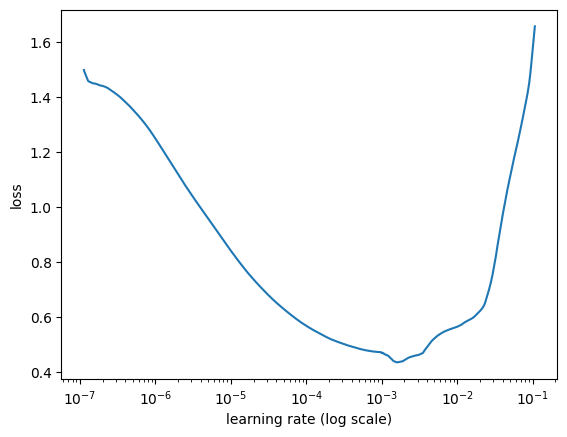

In [17]:
learner.lr_find(show_plot=True, max_epochs=2)

In [18]:
learner.fit_onecycle(lr=10e-3, epochs=1)
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('bertspam--classifier')



begin training using onecycle policy with max lr of 0.01...
743/743 [==============================] - 525s 671ms/step - loss: 0.6850 - accuracy: 0.8297 - val_loss: 0.4643 - val_accuracy: 0.8565


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
